<center><img src='https://drive.google.com/uc?export=view&id=12CrUdXDAiltLBT26sG7HZ_HciIhvGyT8'></center>

# Statistical machine learning - Notebook 8, version for tutors
**Author: Michał Ciach, Dorota Celińska-Kopczyńska**  
Exercises denoted with a star \* are optional. They may be more difficult or time-consuming.  

## Description


In today's class, we will analyze the properties of $k$-fold cross validation, the Bootstrap, and feature selection techniques.  


In [1]:
!pip install --upgrade gdown
!gdown https://drive.google.com/uc?id=1bNShmfSuFvB6gGCjFpRFDGj7Jqes3yRA
!gdown https://drive.google.com/uc?id=1GobUkfo-GR6rmekxgy4gCiHeaCsk9_Ta

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0
Downloading...
From: https://drive.google.com/uc?id=1bNShmfSuFvB6gGCjFpRFDGj7Jqes3yRA
To: /content/8. protein_lengths.tsv
100% 29.3M/29.3M [00:01<00:00, 21.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GobUkfo-GR6rmekxgy4gCiHeaCsk9_Ta
To: /content/8. BDL municipality incomes 2015-2020.csv
100% 228k/228k [00:00<00:00, 66.2MB/s]


## Data & library imports

In [2]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rd
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind, pearsonr, norm
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
import sklearn.datasets
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from statsmodels.formula.api import ols


In [3]:
protein_lengths = pd.read_csv('8. protein_lengths.tsv', sep='\t')
protein_lengths['LogLength'] = np.log10(protein_lengths['Protein length'])
protein_lengths

,Scientific name,Common name,Protein ID,Protein length,LogLength
0,Homo sapiens,Human,NP_000005.3,1474,3.168497
1,Homo sapiens,Human,NP_000006.2,290,2.462398
2,Homo sapiens,Human,NP_000007.1,421,2.624282
3,Homo sapiens,Human,NP_000008.1,412,2.614897
4,Homo sapiens,Human,NP_000009.1,655,2.816241
...,...,...,...,...,...
648731,Imleria badia,Bay bolete (mushroom),KAF8560453.1,494,2.693727
648732,Imleria badia,Bay bolete (mushroom),KAF8560454.1,737,2.867467
648733,Imleria badia,Bay bolete (mushroom),KAF8560455.1,554,2.743510
648734,Imleria badia,Bay bolete (mushroom),KAF8560456.1,813,2.910091


In [4]:
human_protein_lengths = protein_lengths.loc[protein_lengths['Common name'] == 'Human'].copy()
# Note: without .copy(), some versions of Pandas may return a View.
# This may interfere with adding a new column to human_protein_lengths.
human_protein_lengths.describe()

,Protein length,LogLength
count,136193.000000,136193.000000
mean,692.655775,2.711540
std,746.993628,0.329892
min,12.000000,1.079181
25%,316.000000,2.499687
50%,514.000000,2.710963
75%,842.000000,2.925312
max,35991.000000,4.556194


In [1]:
diabetes = sklearn.datasets.load_diabetes(as_frame=True, scaled=False)['frame']
diabetes['sex'] -= 1
diabetes

NameError: name 'sklearn' is not defined

## Estimating the test error of regression with cross-validation

Cross-validation is a technique to estimate the test error of a prediction algorithm (either a classifier or a regression). The idea is to divide the training data set into $k$ parts and, for each part, use it as the test set and the rest as the training set. We will see how well this approach approximates a true test error and what happens for different values of $k$.  

To evaluate models, we typically partition our data set into three subsets: a *training set* on which we train our models, a *validation set* on which we test our models to select the best one, and a *test set* on which we do a final evaluation of our model and, e.g., compare it to a baseline model. One of the approaches to cross-validation is to hold out a portion of the data set as the test set and to split the remaining data into a series of validation sets and training sets.

You should be aware that sometimes people reverse the meaning of the *validation* and *test* sets. This is the case in the picture below, which is taken from Wikipedia—it depicts a series of test sets rather than validation sets. Although the terminology is inconsistent, the general idea stays the same, so if you have a good understanding of how cross-validation works, you won't be confused.


<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/K-fold_cross_validation_EN.svg/1920px-K-fold_cross_validation_EN.svg.png'>

*A diagram representing the k-fold cross-validation.       
Source: https://commons.wikimedia.org/wiki/File:K-fold_cross_validation_EN.svg*
</center>

**Exercise 1.** In this exercise, we will build a linear regression model to predict the progression of diabetes. We will evaluate the model using k-fold cross-validation and check how well the k-fold cross-validation approximates the model's true test error.  

We will use the `diabetes` data frame, which is loaded in the *Data & modules* section. The data frame contains patients' age, sex, BMI (body mass index), bp (average blood pressure), and six blood serum measurements (s1-s6; see [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) for their description). The data frame also contains a measure of the progression of the disease within one year after those measurements were taken (the 'target' column). Let $R$ be the number of rows in this data set.

1. Inspect the `diabetes` data frame. Are there any categorical variables? How are they encoded? Do they all have similar scales (i.e., are they expressed in the same units of measurement, and do they take similar values)?   
  1.1\* Optionally, scale the non-categorical variables so that they have a zero mean and a unit standard deviation.   
  1.2\* Check how scaling influences the model's performance in points 5-9 of this exercise.    
2. Permute the rows of the data frame randomly to eliminate any data grouping that could bias the estimation of the errors. You can use the `sample(frac=1)` command.  
3. Create a data frame with the first $T=50$ observations. This will be our *test set* - our model will need to predict the target variable (i.e., the progression of diabetes) on this data set, but it will not see it during training. The RMSE of prediction on this set is called the *test error*.  
4. Create a data frame with the remaining $R-T$ observations. This will be our *full training set*, where our model will learn how to make predictions. The RMSE of prediction on this set is called the *training error.*  
5. Using the full training data set, create a linear regression model to predict the target variable based on all ten explanatory variables in the data.
Predict the target variable for the test set and calculate the value of the test error.  
  5.1. Is the test error higher or lower than the training error? Should it be? Why?
6. Now, we will implement k-fold cross-validation to predict the test error using only the observations from the training data set. Create a list with several values of the $k$ parameter, including 5, 10 (the two most commonly used values), 15, 60, and the size of the full training set $R-T$ (for a so-called *leave-one-out* cross-validation).  
7. For each value of $k$, perform a $k$-fold cross-validation. For $i=1,\dots, k$:  
  7.1. Select observations $(i-1)\lfloor (R-T)/k \rfloor$ up to $i\lfloor (R-T)/k \rfloor$ from the full training data set and save them as the *validation set*. Save the remaining observations as a *partial training set*.  
  7.2. Create a linear regression model on the partial training set. Calculate its predictions for the validation set. Calculate the validation error (RMSE) and store it in a list.  
8. For each $k$, calculate the mean and standard deviation of the corresponding validation errors.   
  8.1. Can you see some trends in those values? Can you explain it?  
  8.2. Which $k$ best approximates the true test error?
9. Plot the distributions of errors on histograms.   
  9.1. Which $k$ gives you the most information about the distribution of the test error?         
10. In point 7, we have iterated over $i=1,\dots, k$. Do you see a potential problem or inefficiency when $k$ does not divide $R-T$? Does it make sense to iterate over $i=1,\dots, k+1$? What are the possible advantages and disadvantages?

In [30]:
# 1.
# Categorical variable - sex
diabetes

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,1.0,32.1,101.00,157.0,93.2,38.0,4.00,4.8598,87.0,151.0
1,48.0,0.0,21.6,87.00,183.0,103.2,70.0,3.00,3.8918,69.0,75.0
2,72.0,1.0,30.5,93.00,156.0,93.6,41.0,4.00,4.6728,85.0,141.0
3,24.0,0.0,25.3,84.00,198.0,131.4,40.0,5.00,4.8903,89.0,206.0
4,50.0,0.0,23.0,101.00,192.0,125.4,52.0,4.00,4.2905,80.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,60.0,1.0,28.2,112.00,185.0,113.8,42.0,4.00,4.9836,93.0,178.0
438,47.0,1.0,24.9,75.00,225.0,166.0,42.0,5.00,4.4427,102.0,104.0
439,60.0,1.0,24.9,99.67,162.0,106.6,43.0,3.77,4.1271,95.0,132.0
440,36.0,0.0,30.0,95.00,201.0,125.2,42.0,4.79,5.1299,85.0,220.0


In [31]:
columns_to_scale  = diabetes.columns.drop('target', 'sex')
scaler = StandardScaler()
diabetes.loc[:, columns_to_scale] = scaler.fit_transform(diabetes[columns_to_scale])
#diabetes = pd.get_dummies(diabetes, columns=['sex'], drop_first=True)

In [32]:
data = diabetes.sample(frac=1).reset_index(drop=True)
attributes  = data.columns.drop('target')
X = data[attributes]
y = data['target']

T = 50
X_test = X.loc[:T]
y_test = y.loc[:T]

X_train = X.loc[T:]
y_train = y.loc[T:]

In [33]:
model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("Training RMSE:", rmse_train)

y_test_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test RMSE:", rmse_test)

Training RMSE: 53.24671532271728
Test RMSE: 55.97430152326856


k = 392: Mean Validation RMSE = 44.3529805283523, Std Dev = 32.07502737098726
k = 60: Mean Validation RMSE = 52.31968276001366, Std Dev = 15.164910599653266
k = 15: Mean Validation RMSE = 54.32295409408877, Std Dev = 6.7682555700789555
k = 10: Mean Validation RMSE = 54.55303761100792, Std Dev = 3.4498947046129276
k = 5: Mean Validation RMSE = 54.92748491506941, Std Dev = 2.7591183347057426


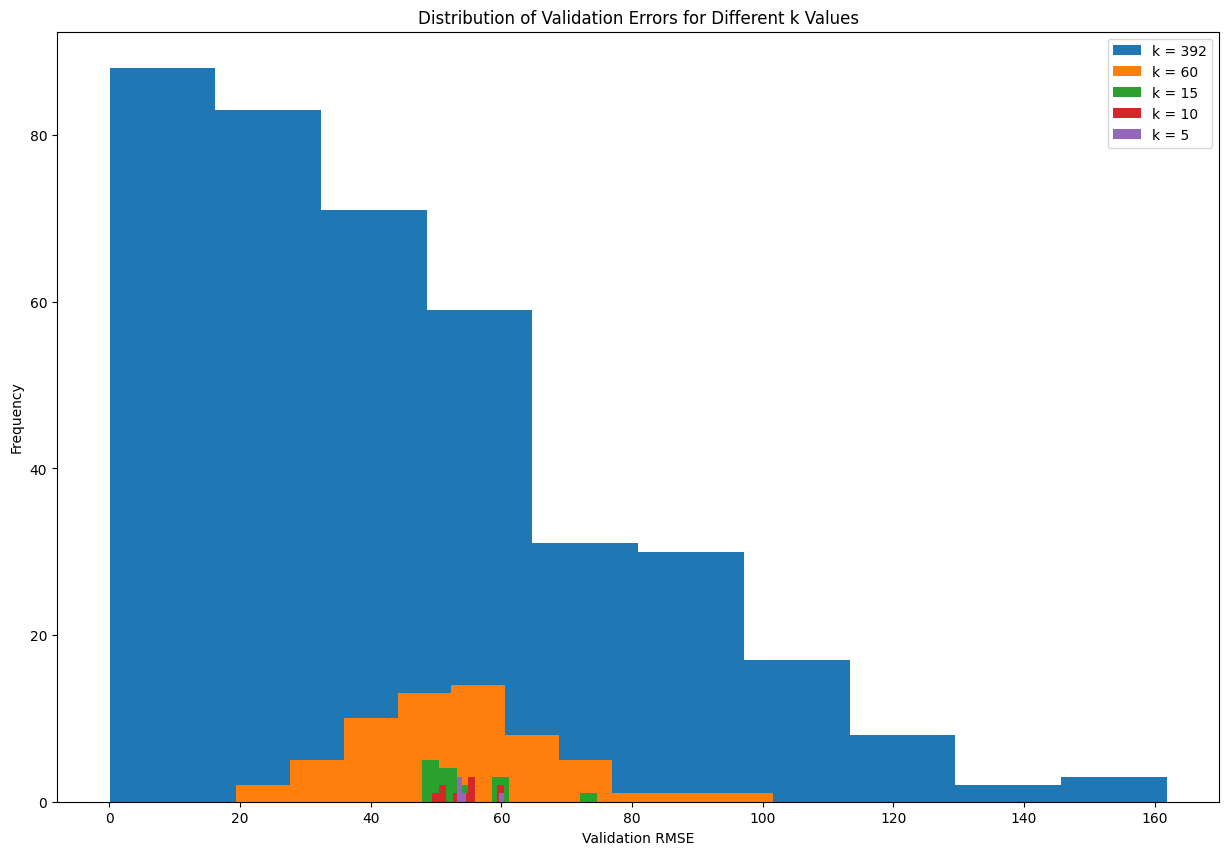

In [34]:
# List of k values
k_values = [5, 10, 15, 60, len(X_train)]  # The last value is leave-one-out cross-validation

# Store results for analysis
results = []

for k in k_values[::-1]:
    fold_size = len(X_train) // k
    validation_errors = []

    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size if i < k - 1 else len(X_train)

        X_val = X_train.iloc[start:end]
        y_val = y_train.iloc[start:end]

        X_partial_train = pd.concat([X_train.iloc[:start], X_train.iloc[end:]])
        y_partial_train = pd.concat([y_train.iloc[:start], y_train.iloc[end:]])

        model = LinearRegression()
        model.fit(X_partial_train, y_partial_train)

        # Predict on the validation set
        y_val_pred = model.predict(X_val)
        rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
        validation_errors.append(rmse_val)

    # Calculate mean and standard deviation of validation errors
    mean_val_error = np.mean(validation_errors)
    std_val_error = np.std(validation_errors)

    results.append({
        'k': k,
        'mean_val_error': mean_val_error,
        'std_val_error': std_val_error,
        'validation_errors': validation_errors
    })

    # Print results for each k
    print(f"k = {k}: Mean Validation RMSE = {mean_val_error}, Std Dev = {std_val_error}")

# Plotting the distributions of errors
plt.figure(figsize=(15, 10))
for result in results:
    plt.hist(result['validation_errors'], bins=10, alpha=1, label=f"k = {result['k']}")

plt.xlabel('Validation RMSE')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Distribution of Validation Errors for Different k Values')
plt.show()


**Exercise 2.** Let us make a better model! In Exercise 1, we assumed that the effect of s2 (LDL, low-density lipoproteins) and s3 (HDL, high-density lipoproteins) are additive - this means that these variables work "independently" from each other. However, we may reasonably expect a positive interaction between them: if a patient already has a lot of HDL, then any increase in LDL is much worse for them than if the patient had a low HDL. In linear regression, we model that by calculating a product of these variables and treating it as a new variable.

So, including a product of LDL and HDL in our model may increase its accuracy by accounting for interactions between those variables. But you know what? Let us go even further and multiply *every* blood serum variable (s1-s6)! What could possibly go wrong?


1. Write down the mathematical equation for the model described above. Try to keep the equation simple.   
2. Copy the `diabetes` data frame. Add the products of variables s1 to s6 to it (note: we want to multiply each pair only once - do not make a model with both $s_1 s_2$ and $s_2 s_1$).  
  2.1. What would happend if you actually *did* make a model with both $s_1 s_2$ and $s_2 s_1$ variables?
3. Withhold $T=50$ observations (the same ones as in Exercise 1) from the new data frame as the test data set and create a training data set accordingly.  
4. Create a linear regression model on the training data set. Calculate its training and test RMSE. Compare the errors with the model from Exercise 1.  
  4.1. Did the train RMSE decrease? Why?  
  4.2. Did the test RMSE decrease as well? Why?  
  4.3. Is the test RMSE considerably higher than the train RMSE? Is the difference between those errors larger than in Exercise 1?  


In [40]:
data_extended = data.copy()

# Add products of serum variables to the DataFrame
for i in range(1, 6):
    for j in range(i + 1, 7):
        data[f's{i}s{j}'] = data[f's{i}'] * data[f's{j}']

# Show the first few rows of the extended DataFrame
print(data_extended)

          age       sex       bmi        bp        s1        s2        s3  \
0   -1.490592 -0.938537 -0.085153 -0.843032 -1.392590 -1.653764  1.100002   
1   -0.574155 -0.938537 -1.331437 -1.060177 -1.884362 -2.193617  1.100002   
2   -0.039567 -0.938537 -1.354097  0.242695  0.574497  0.788740 -0.293235   
3   -1.185113  1.065488 -0.221112  0.532222  0.487714  0.841408 -0.835049   
4   -0.650525  1.065488  1.251769  0.025550  0.256292  0.663652 -0.912451   
..        ...       ...       ...       ...       ...       ...       ...   
437 -2.177920  1.065488 -0.968882 -0.553505 -0.524757 -0.521390  0.635590   
438 -0.956004  1.065488 -0.991541 -0.336359 -0.842963 -0.521390  0.016374   
439 -0.039567  1.065488  1.501026  2.052240  1.847318  1.585352 -0.448039   
440 -0.039567 -0.938537 -1.082180 -0.553505 -0.177624 -0.402886  1.564414   
441  0.647761  1.065488  1.251769  1.183659 -0.466902  0.025046 -0.680245   

           s4        s5        s6  ...      s2s3      s2s4      s2s5  \
0  

In [41]:
attributes_extended  = data_extended.columns.drop('target')
X_extended = data_extended[attributes_extended]
y_extended = data_extended['target']

T = 50
X_extended_test = X_extended.loc[:T]
y_extended_test = y_extended.loc[:T]

X_extended_train = X_extended.loc[T:]
y_extended_train = y_extended.loc[T:]

In [42]:
model_extended = LinearRegression()
model_extended.fit(X_extended_train, y_extended_train)

y_extended_train_pred = model_extended.predict(X_extended_train)
rmse_extended_train = np.sqrt(mean_squared_error(y_extended_train, y_extended_train_pred))
print("Training RMSE:", rmse_extended_train)

y_extended_test_pred = model_extended.predict(X_extended_test)
rmse_extended_test = np.sqrt(mean_squared_error(y_extended_test, y_extended_test_pred))
print("Test RMSE:", rmse_extended_test)

Training RMSE: 51.64056696309918
Test RMSE: 57.687173688667876


**Exercise 3.** Even if a model is reasonable, it may perform poorly if it is too flexible and overfits the data. In the previous exercise, you may (or may not have) concluded that the new model overfits. However, these conclusions could be more robust - after all, we have checked the performance only on a single selected test set. Maybe the result was just a random artifact caused by an unfortunate permutation of the rows of `diabetes` in Exercise 1? That is where cross-validation again comes in handy.    

1. Select your favorite value of $k$ for a k-fold cross-validation.  
2. Use the `cross_val_score` function from the `sklearn` library to evaluate the "complex" model from Exercise 2 and the "simple" model from Exercise 1 (use all observations from `diabetes`). To evaluate a model with RMSE, use a keyword argument `scoring='neg_root_mean_squared_error'`.   
  2.1. Compare the average test errors of the two models. Can you conclude that the complex model overfits?  
  2.2. Check the standard deviation of the errors. Is it much lower than the average of the errors? Is the conclusion about overfitting robust, or could it occur just by chance due to random errors in estimating the mean?      
  2.3. \* Can you come up with some statistical method to decide whether the test RMSE of the complex model is higher than the RMSE of the simple model rather than being caused just by random chance?
3. \* Implement a k-fold cross-validation and, in each iteration, save *both* the training and the test RMSE of the fitted model (or figure out how to get the train RMSE with `sklearn`).   
  3.1 Calculate the mean and standard deviation of the four errors. Analyze the difference between the two models' test MSEs and the train MSEs. Does this provide some additional useful information compared to just the test MSE?  
5. Can the conclusion about overfitting depend on the value of $k$? Why/why not?  


In [47]:
k = 10
simple_scores = cross_val_score(LinearRegression(), X, y, cv=k, scoring='neg_root_mean_squared_error')
complex_scores = cross_val_score(LinearRegression(), X_extended, y_extended, cv=k, scoring='neg_root_mean_squared_error')

simple_mean_rmse = -simple_scores.mean()
simple_std_rmse = simple_scores.std()
complex_mean_rmse = -complex_scores.mean()
complex_std_rmse = complex_scores.std()

# Print the results
print("Simple Model:")
print(f"Mean RMSE: {simple_mean_rmse}, Std Dev RMSE: {simple_std_rmse}")
print("Complex Model:")
print(f"Mean RMSE: {complex_mean_rmse}, Std Dev RMSE: {complex_std_rmse}")

Simple Model:
Mean RMSE: 55.22491717231806, Std Dev RMSE: 4.871194669239658
Complex Model:
Mean RMSE: 55.22491717231808, Std Dev RMSE: 4.8711946692396335


## Analyzing estimators with the Bootstrap

*Bootstrap* is a non-parametric technique used to quantify estimation uncertainty and perform hypothesis testing. As you may remember, *non-parametric* means that you do not need to know the probability distribution of your data to use this technique. Therefore, Bootstrap allows you to test hypotheses for any data set, not just normally distributed ones. However, it has the same downsides as all the other non-parametric techniques. In particular, it is difficult to analyze theoretically, so we cannot really say how well it performs by analyzing it, as in the case of the Student's t-test.  

The idea behind Bootstrap is as follows. Suppose we have a statistical sample of size $n$, $X_1, \dots, X_n$, and some statistic (e.g., the mean or the variance) that we compute from this sample, denoted $f(X_1, \dots, X_n)$, to estimate some parameter. Suppose we want to quantify the uncertainty of this estimation but need to know how to calculate the variance of $f(X_1, \dots, X_n)$ analytically. In this case, we can sample $n$ observations **with replacement** from $X_1, \dots, X_n$ to get a new sample $X_1^*, \dots, X_n^*$, calculate $f(X_1^*, \dots, X_n^*)$, and repeat this procedure multiple times to get a sample of values of the statistic $f$. It turns out that the distribution of $f$ obtained this way mimics its true distribution.   

It is important to remember that to get a proper result; we need to get a sample of the same size (otherwise, we change the parameters of our statistic, e.g., the mean computed from a smaller sample will have a higher variance), and to sample with replacement (otherwise, if we sample without replacement, we just get a permutation of the values).

**Exercise 4.** In this exercise, we will use the bootstrap technique to analyze the properties of the estimator of the standard deviation of a protein log-length. We will then decide which type of confidence interval for the mean we can use.  

Recall that there are three common types of a confidence interval for the mean of a normally distributed population. The first type is for a known $\sigma$ and is given by:
$$\left (\hat{\mu} - q_{(1+\alpha)/2}\frac{\sigma}{\sqrt{N}},\quad \hat{\mu} + q_{(1+\alpha)/2}\frac{\sigma}{\sqrt{N}} \right ), $$
and the second type, for an unknown $\sigma$, is given by:
$$\left (\hat{\mu} - t_{(1+\alpha)/2, N-1}\frac{\hat{\sigma}}{\sqrt{N}},\quad \hat{\mu} + t_{(1+\alpha)/2, N-1}\frac{\hat{\sigma}}{\sqrt{N}} \right ).$$
The third type called an *asymptotic* confidence interval, is given by the same formula as the first one but with estimated standard deviation (i.e., put $\hat{\sigma}$ instead of $\sigma$ in the equation). If we can estimate $\sigma$ *very precisely*, we may use this third type to obtain a more precise result (i.e., a shorter interval).   

1. Select $N=50$ random samples from the `human_protein_lengths` data and put them into a new data frame called `sample`. Calculate the standard deviation of the sampled protein log-lengths.  
2. Now, we will use the bootstrap to estimate the distribution of the estimator. Repeat the following $R=10 000$ times:  
  2.1. Resample the observations from the `sample` data frame, e.g., using the `sample.sample()` method.  
  2.2. Calculate the standard deviation from the resampled observations and store it in a list.   
3. Plot the obtained bootstrap replicates of the standard deviation on a histogram. Calculate the estimator's mean and standard deviation and check its coefficient of variation.    
  3.1. In your opinion, is the standard deviation estimated sufficiently precisely to use the asymptotic confidence interval?  
  3.2. How does the error in estimating the standard deviation influence the length of the asymptotic confidence interval?   
  3.3. Create a histogram showing bootstrapped lengths of the asymptotic confidence interval. To calculate the lengths, you can use the bootstrapped replicates of the standard deviation.   
  3.4. Do the answers to the previous points depend on $N$?  
4. Estimate the true distribution of the standard deviation estimator. To do this, draw $R$ samples of size $N$ of the log-lengths of human proteins and calculate the standard deviation for each sample.  
  4.1. Plot the estimator's obtained $R$ values on a histogram and compare it to the histogram of bootstrapped replicates. Are the distributions similar?  
  4.2. Use the $R$ values to estimate the estimator's expected value and standard deviation. Compare it to the values obtained with the bootstrap. Are the bootstrap estimates similar to the true parameters of this estimator?  


In [ ]:
## Put your code here


True std: 0.32989112244952207
Sampled mean: 2.671060777582481
Sampled std: 0.30433457055553276
Bootstrapped mean and std of stds: 0.3003 0.0271
Bootstrapped CV of the estimator of the std: 0.0901
True mean and std of stds: 0.3244 0.0351
True CV of the estimator of the std: 0.1083


**Exercise 5.** In this exercise, we will use Bootstrap to estimate the bias of the estimator of standard deviation. It works like this. Let $X = X_1, \dots, X_N$ be a random sample from a population, and let $\hat\sigma(X)$ be the estimator of the standard deviation $\hat\sigma(X) = \sqrt{\sum (X_i - \bar X)^2 / N}$. Let $X^*_1, \dots, X^*_B$ be the bootstrap replicates from $X$, where $X^*_1 = X^*_{1,1}, \dots, X^*_{1, N}$. To estimate the bias of $\hat\sigma$, we simply calculate

$$\frac{1}{B}\sum_{i=1}^B (\hat\sigma(X^*_i) - \hat\sigma(X)).$$

*Warning.* This procedure works for a broad class of estimators (like the common estimators of the standard deviation or the variance) but only for some of them. You should be careful if you want to use it in your analyses. You can read more in Efron and Tibshirani's book *An Introduction to the Bootstrap*.  

1. Estimate the bias of $\hat\sigma$ using the bootstrap replicates from the previous exercise. Does the result suggest that the estimator is biased or unbiased? Is this a correct result?
2. What if you use $N-1$ instead of $N$ in the estimator's denominator, i.e., an estimator based on the unbiased variance estimator?  
3. Verify your results by estimating the bias of $\hat\sigma$ using random samples of proteins and the true value of the standard deviation of the log-length.  
4. \* Can you briefly argue why this bias estimation works?  
5. How does the estimator's bias influence the length of the asymptotic confidence intervals—on average, are they too short, too long, or neither? What is the consequence of the actual confidence level of this type of interval?


In [ ]:
## Put your code here


Bias estimated with the bootstrap: -0.004015539746344943
Bias estimated properly: -0.005484451101218979


**Exercise 6.\*\*** One of the applications of estimating a distribution is performing hypothesis testing when it is difficult or impossible to calculate the distribution of a test statistic analytically. Recall that hypothesis testing proceeds as follows:  
1. We set a null hypothesis $H_0$, and alternative hypothesis $H_1$, and a test statistic $T$ that will give the test a high statistical power.  
2. We derive the distribution of $T$ assuming $H_0$ is true.  
3. We calculate the observed value of the test statistic, $T^*$.  
4. We define the critical region $C_{T^*}$ such that $T \in C_{T^*}$ is unlikely under $H_0$, but more likely under $H_1$. Often, $C = \{t \in \mathbb{R}: t \leq -|T^*| \text{ or } t \geq |T^*|\}$. The critical region is selected to get as high power of the test as possible.
4. We calculate the p-value $p = \mathbb{P}(T \in C_{T^*} | H_0)$, i.e. the probability that $T$ falls into the critical region $C_{T^*}$ assuming $H_0$ is true. Low p-values indicate that $H_0$ is false. The *significance level* of the test is the threshold of the p-value below which we discard $H_0$.     

When we do not know the distribution of the test statistic, we can use Bootstrap to complete step 2. To do this, we obtain bootstrap replicates of our statistical sample and calculate the value of $T$ in each replicate.  
However, when we estimate the distribution of $T$, we need to ensure that $H_0$ is true. To do this, we usually need to transform our sample. We will see how to do this by testing the equality of mean log-lengths of proteins in two organisms.  

1. Write a function that takes two vectors and returns the value of the test statistic $T$ of the [Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test).  
2. Select two random samples of protein log-lengths from two organisms, each of size $N=20$.  
3. Compute the observed value of Welsch's test statistic, $T^*$, for these two samples.   
4. We will use Bootstrap to obtain the distribution of $T$ under the null hypothesis that the mean log-lengths are equal. Note that, in the following substeps, we equalize the means in the *samples*, not in the *populations* - we pretend that we don't have any other data than the two samples of size $N$ and do not know the true means. Therefore, the null hypothesis will be valid only asymptotically (i.e., for infinite sample sizes).
  4.1. Calculate the mean log-lengths of proteins in both samples.  
  4.2. Subtract the corresponding mean from each sample so that both log-length vectors have a zero mean.  
  4.3. For 1000 times or more, resample the log-lengths from both vectors and compute the test statistic $T$ value.  
  4.4. Visualize the distribution of $T$ under the null hypothesis on a histogram.   
5. Calculate the p-value by checking the proportion of bootstrapped values of $T$ that are at least as extreme as $T^*$ (for an alternative hypothesis of your choice). Do you reject the null hypothesis?
6. Perform a Welch's t-test using the `scipy.ttest_ind` function and compare the results. Are the p-values similar?  
  6.1. You may use this function's output to verify whether you have computed $ T*$ properly.

In [ ]:
## Put your code here


Value of the test statistic: -0.8627507281024508
Bootstrapped p-value: 0.3842
Results of the t-test: TtestResult(statistic=-0.8627507281024507, pvalue=0.39396510299003107, df=36.13188855999976)


## Model selection

**Exercise 7.**  In Exercises 2 and 3, we have seen that seemingly reasonable models may perform worse if they have too many variables. High flexibility allows them to learn spurious signals in the training data set that do not generalize to new observations and decrease performance. However, some of the additional variables may be useful. How, then, do we pick the best features for our model?  

In principle, we could inspect all the possible combinations of features. However, this is often prohibitively expensive computationally. Typically, we use one of the following heuristic approaches:  
1. *forward* model selection, where we start with an empty model and iteratively add one feature that gives the best improvement,
2. *backward* model selection, where we start with a full model (i.e., with all the features that we can take), and we iteratively remove one feature; we select the feature such that its removal gives the best improvement,
3. *forward-backward* model selection, where we start with an empty model and iteratively either add or remove one feature, depending on which gives the best improvement,  
4. *backward-forward* model selection, which you can figure out now.  

All the procedures iterate either until we reach a desired number of variables or until we can no longer improve our model. There are several methods to evaluate the improvement of our model that we get by adding or removing a feature. The most general one is the test error estimated with k-fold cross-validation. This exercise will use this technique to select the best model to predict diabetes progression.   
  
1. Create a `LinearRegression` object with `fit_intercept=False`. In this exercise, we add the intercept manually because we want to include it in the model selection procedure. Because of this, add a constant column with values equal to 1, called `intercept`, to data from Exercise 2.
2. Use the `SequentialFeatureSelector` function from `scipy` to perform a forward model selection on data from Exercise 2. Use 10-fold cross-validation to estimate the error. Look up the documentation of this function online to correctly specify the keyword arguments `n_features_to_select`, `cv`, and `tol`.  
  2.1. Inspect the new model. Estimate its test error with cross-validation with the same $k$ you used in Exercises 2 and 3. Did you get a better test error? If yes, does it mean you have found the best set of features?       
  2.2. Run the function a few times. Did you get the same model each time? Why/why not? Do you suspect that this is a feature of the model selection technique (i.e., that it always works like this on any data) or a feature of the data set?  
  2.2. Experiment with different values of the `tol` parameter. Did increasing or decreasing it allow you to find a better model? Why?  
3. Now, perform a backwards model selection using `SequentialFeatureSelector`, starting from a full model from Exercise 2.  
  3.1. Did you obtain the same model as in point 3? If not, which model is better?  
  3.2. What are the possible advantages and disadvantages of the backward strategy compared to the forward strategy?   
  3.3. Experiment with different values of the `tol` parameter. Did increasing or decreasing it allow you to find a better model? Why?  
4. \** Implement your own forward-backward procedure. Iterate until the difference between the new and the current model RMSE is not larger than 0.01 (i.e., we modify our model even if we get a slightly worse RMSE). We set this threshold to search more models - a temporary decrease in model performance may allow us to discover a better model.  
  4.1. What risks do we run into when we can increase and decrease model performance in consecutive steps? How should we handle them?  
  4.2. Use your implementation to select the best set of features for predicting city incomes. Was removing a feature beneficial at any step?  
  4.3. Did you obtain a better performance than using a simple forward strategy?  
  4.4. Did the error threshold of 0.01 allow you to find a better model than an error threshold equal to zero (i.e., accepting a new model only if it improves over the current one)?  

In [43]:
data_extended

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,...,s2s3,s2s4,s2s5,s2s6,s3s4,s3s5,s3s6,s4s5,s4s6,s5s6
0,-1.490592,-0.938537,-0.085153,-0.843032,-1.392590,-1.653764,1.100002,-1.606102,-1.080705,-0.719320,...,-1.819143,2.656115,1.787231,1.189585,-1.766715,-1.188777,-0.791253,1.735722,1.155301,0.777372
1,-0.574155,-0.938537,-1.331437,-1.060177,-1.884362,-2.193617,1.100002,-1.606102,-1.180551,-1.415982,...,-2.412982,3.523174,2.589678,3.106123,-1.766715,-1.298608,-1.557583,1.896086,2.274213,1.671640
2,-0.039567,-0.938537,-1.354097,0.242695,0.574497,0.788740,-0.293235,0.721302,0.247776,-1.154734,...,-0.231286,0.568920,0.195431,-0.910785,-0.211511,-0.072656,0.338608,0.178721,-0.832912,-0.286115
3,-1.185113,1.065488,-0.221112,0.532222,0.487714,0.841408,-0.835049,0.721302,0.433288,1.196502,...,-0.702617,0.606910,0.364572,1.006747,-0.602323,-0.361816,-0.999137,0.312531,0.863040,0.518429
4,-0.650525,1.065488,1.251769,0.025550,0.256292,0.663652,-0.912451,0.721302,0.311593,0.151508,...,-0.605550,0.478694,0.206790,0.100549,-0.658153,-0.284313,-0.138244,0.224753,0.109283,0.047209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,-2.177920,1.065488,-0.968882,-0.553505,-0.524757,-0.521390,0.635590,-0.830301,-0.836933,-1.154734,...,-0.331390,0.432911,0.436369,0.602067,-0.527731,-0.531946,-0.733937,0.694906,0.958776,0.966434
438,-0.956004,1.065488,-0.991541,-0.336359,-0.842963,-0.521390,0.016374,-0.830301,-1.322752,-0.806403,...,-0.008537,0.432911,0.689670,0.420451,-0.013595,-0.021658,-0.013204,1.098282,0.669557,1.066670
439,-0.039567,1.065488,1.501026,2.052240,1.847318,1.585352,-0.448039,1.497104,1.501706,0.499840,...,-0.710299,2.373437,2.380732,0.792422,-0.670760,-0.672822,-0.223947,2.248210,0.748312,0.750612
440,-0.039567,-0.938537,-1.082180,-0.553505,-0.177624,-0.402886,1.564414,-0.830301,-1.436589,-1.938479,...,-0.630281,0.334517,0.578782,0.780986,-1.298934,-2.247419,-3.032583,1.192801,1.609521,2.784797


In [52]:
data_extended['intercept'] = 1
attributes_extended_intercept = ['intercept'] + list(attributes_extended)
model = LinearRegression(fit_intercept=False)
X = data_extended[attributes_extended_intercept]
y = data_extended['target']

# Create the SequentialFeatureSelector with forward selection
sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward', cv=10, tol=1e-100)

# Fit the SequentialFeatureSelector
sfs.fit(X, y)

# Get the selected features
selected_features = sfs.get_support(indices=True)
selected_feature_names = X.columns[selected_features]
print("Selected features:", selected_feature_names)

# Fit the model with the selected features
model.fit(X.iloc[:, selected_features], y)

# Evaluate the new model using cross-validation
cv_scores = cross_val_score(model, X.iloc[:, selected_features], y, cv=10, scoring='neg_root_mean_squared_error')

# Calculate mean and standard deviation of RMSE scores
mean_rmse = -cv_scores.mean()
std_rmse = cv_scores.std()

# Print the results
print("Model with Selected Features:")
print(f"Mean RMSE: {mean_rmse}, Std Dev RMSE: {std_rmse}")

Selected features: Index(['intercept', 'sex', 'bmi', 'bp', 's1', 's2', 's5', 's5s6'], dtype='object')
Model with Selected Features:
Mean RMSE: 54.042213712292735, Std Dev RMSE: 4.141898729006715


In [ ]:
## Put your code here


Scikit selected model, forward: Index(['sex', 'bmi', 'bp', 's1', 's5', 's6', 's1s3', 's1s4', 's2s5', 's3s6',
       's4s6', 's5s6'],
      dtype='object')
MSE, 10-fold: 53.941211416521526
sex -22.9
bmi 5.43
bp 1.15
s1 -1.03
s5 8.73
s6 -3.79
s1s3 -0.0
s1s4 -0.13
s2s5 0.26
s3s6 0.01
s4s6 0.33
s5s6 0.47
Scikit selected model, backward: Index(['sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 's1s4', 's1s5',
       's2s5', 's2s6', 's3s5', 's3s6', 's4s6', 'intercept'],
      dtype='object')
MSE, 10-fold: 54.05718541463872
sex -22.9
bmi 5.43
bp 1.15
s1 -1.03
s2 8.73
s3 -3.79
s4 -0.0
s5 -0.13
s6 0.26
s1s4 0.01
s1s5 0.33
s2s5 0.47

Adding age
MSE: 79.94423817838604
Adding sex
MSE: 132.85242960931512
Adding bmi
MSE: 65.34378316679596
Adding bp
MSE: 70.00204769047657
Adding s1
MSE: 76.0441374698092
Adding s2
MSE: 80.01420052987513
Adding s3
MSE: 97.91791632697513
Adding s4
MSE: 70.81347845603506
Adding s5
MSE: 68.67777241483607
Adding s6
MSE: 71.77933832850758
Adding s1s2
MSE: 89.631273616

<center><img src='https://drive.google.com/uc?export=view&id=12CrUdXDAiltLBT26sG7HZ_HciIhvGyT8'></center>